This is a notebook to explore opSim outputs in different ways, mostly useful to supernova analysis. We will look at the opsim output called (`minion_1016`)[https://confluence.lsstcorp.org/display/SIM/Summary+Table+Column+Descriptions].
Other relevant OpSim outputs are listed on  a [confluence page](https://confluence.lsstcorp.org/display/SIM/Operations+Simulator+Benchmark+Surveys). All of the newer outputs are in the format of sqlite databases (zipped up to save space), while older OpSim versions are in ASCII files. The database table which I think has all of the information we will need is the `Summary` Table. The quantities in the columns of this table are described (here)[https://confluence.lsstcorp.org/display/SIM/Summary+Table+Column+Descriptions]. The OpSim outputs are official products that the LSST project provides. This notebook will demonstrate a way of exploring these outputs (which is by no means official or project supplied).

``Note:`` The `Summary` Table is only about a GB in size, and has ~ million rows. For newish laptops, this is a small table and can be easily read into memory. For more constrained memory systems or computations that require a lot of memory, this may be a bad thing to do.

``Gotcha``: The column `obsHistID` is unique identifier of OpSim observations. Very often, you might end up with a table with multiple rows with the same obsHistID, but with other columns (like propID) having different values. These are not different observations, and a SN light curve corresponding to these observations should include only one of these.

### A bit more information about the columns from a SN perspective

The LSST observations are over roughly half of the sky (~20000 sq degrees, or ~`2\pi`). This is covered by 
overlapping pointings of the telescope each covering (~10 sq degrees). These pointings are currently thought of as being located on a grid along with dithers. The grid locations of the pointings are assigned a unique integer called `fieldID` which is associated with its location :(`fieldRa`, `fieldDec` ). The actual location of the pointings (including dithers) are in (`ditheredRA`, `ditheredDec`). There are a number of columns that hold quantities of similar information, and the exact definitions of each quantity is provided in the [description](https://confluence.lsstcorp.org/display/SIM/Summary+Table+Column+Descriptions). For most purposes `filtSkyBrightness` and `FWHMeff` rather than the other similar looking quantities are probably recommended. `PropID` (also described there) refers to proposals under which the observation was taken. For the basic SN purposes, we will want the proposals (Wide Fast Deep (WFD)) and (Deep Drilling Fields (DDF)). The propID for these quantities differs from one opsim output to another. To find out what these are, you can use OpSim utils as in this notebook or look at the `PROPOSAL` table (5 lines) like this : and pick the integers corresponding to DDcosmology1.conf and Universal ...
```
 SELECT * FROM PROPOSAL;
362|../conf/survey/GalacticPlaneProp.conf|WL|27692624|enigma|1189
363|../conf/survey/SouthCelestialPole-18.conf|WL|27692368|enigma|1189
364|../conf/survey/Universal-18-0824B.conf|WLTSS|27692112|enigma|1189
365|../conf/survey/NorthEclipticSpur-18c.conf|WLTSS|27692240|enigma|1189
366|../conf/survey/DDcosmology1.conf|WLTSS|29065424|enigma|1189
```

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
# Required packages sqlachemy, pandas (both are part of anaconda distribution, or can be installed with a python installer)
# One step requires the LSST stack, can be skipped for a particular OPSIM database in question
import opsimsummary as oss
import opsimsummary.summarize_opsim as so
from sqlalchemy import create_engine
import pandas as pd
print so.__file__

/Users/rbiswas/.local/lib/python2.7/site-packages/opsimsummary/summarize_opsim.pyc


In [3]:
# This step requires LSST SIMS package MAF. The main goal of this step is to set DD and WFD to integer keys that 
# label an observation as Deep Drilling or for Wide Fast Deep.
# If you want to skip this step, you can use the next cell by uncommenting it, and commenting out this cell, if all you
# care about is the database used in this example. But there is no guarantee that the numbers in the cell below will work
# on other versions of opsim database outputs

from lsst.sims.maf import db
from lsst.sims.maf.utils import opsimUtils

In [4]:
# DD = 56
# WFD = 54

## Read in OpSim output for modern versions: (sqlite formats)

Here we will use the opsim output minion_1016
I have downloaded this database, unzipped and use the variable dbname to point to its location

In [5]:
# Change dbname to point at your own location of the opsim output
dbname = '/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(dbname)
propID, propTags = opsdb.fetchPropInfo()
DD = propTags['DD'][0]
WFD = propTags['WFD'][0]

In [6]:
print("The propID for the Deep Drilling Field {0:2d}".format(DD))
print("The propID for the Wide Fast Deep Field {0:2d}".format(WFD))

The propID for the Deep Drilling Field 56
The propID for the Wide Fast Deep Field 54


## Read in the OpSim DataBase into a pandas dataFrame

Here we will read the opsim database into a `pandas.DataFrame`

In [7]:
engine = create_engine('sqlite:///' + dbname)

The opsim database is a large file (approx 4.0 GB), but still possible to read into memory on new computers. You usually only need the Summary Table, which is about 900 MB. If you are only interested in the Deep Drilling Fields, you can use the read_sql_query to only select information pertaining to Deep Drilling Observations. This has a memory footprint of about 40 MB.
Obviously, you can reduce this further by narrowing down the columns to those of interest only. For the entire Summary Table, this step takes a few minutes on my computer. 

If you are going to do the read from disk step very often, you can further reduce the time used by storing the output on disk as a hdf5 file and reading that into memory

We will look at three different Summaries of OpSim Runs. A summary of the 
1. Deep Drilling fields: These are the observations corresponding to propID of the variable DD above, and are restricted to a handful of fields
2. WFD (Main) Survey: These are the observations corresponding to the propID of the variables WFD
3. Combined Survey: These are observations combining DEEP and WFD in the DDF. Note that this leads to duplicate observations which must be subsequently dropped.

In [8]:
# Load to a dataframe
# Summary = pd.read_hdf('storage.h5', 'table') # This loads the table from a hdf file which I store as intermediate result, this is extremely quick
# Summary = pd.read_sql_table('Summary', engine, index_col='obsHistID'), #'loads all of the summary table'
# EnigmaDeep  = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID is 366', engine) # loads only the DDF

If we knew ahead of time the proposal ID, then we could have done this quicker using 

In [9]:
OpSim_combined = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID in ({0}, {1})'.format(DD, WFD), engine, index_col='obsHistID')

In [10]:
OpSim_combined.head()

,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,visitTime,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
obsHistID,,,,,,,,,,,,,,,,,,,,,
1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,34.0,...,0.0,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,34.0,...,0.0,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,34.0,...,0.0,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,34.0,...,0.0,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,34.0,...,0.0,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123


This could have duplicates unlike in the case of the OpSim Deep. This is because there are now two proposal IDs both of which may correspond to the same observation. We can check that this is indeed the case by:

In [11]:
len(OpSim_combined) == len(OpSim_combined.index.unique())

False

Dropping the duplicate pointings can be done in the following way. The reset_index() makes 'obsHistID' an ordinary column rather than an index, `drop_duplicates` drops duplicate rows where 

In [12]:
OpSim_combined.reset_index().drop_duplicates(subset='obsHistID', inplace=True)

In [13]:
OpSim_combined.head()

,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,visitTime,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
obsHistID,,,,,,,,,,,,,,,,,,,,,
1,1016,54,316,1.676483,-1.082473,y,2922,59580.033829,0,34.0,...,0.0,105.610378,0.920473,0.0,0.0,1.620307,0.000000,21.021236,1.643930,-1.108924
2,1016,54,372,1.694120,-1.033972,y,2961,59580.034275,0,34.0,...,0.0,105.167017,0.920473,0.0,0.0,0.049266,4.574944,21.026646,1.664257,-1.060423
3,1016,54,441,1.708513,-0.985271,y,2999,59580.034722,0,34.0,...,0.0,104.849578,0.920473,0.0,0.0,0.049298,4.595615,21.030520,1.680878,-1.011722
4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,34.0,...,0.0,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927
5,1016,54,587,1.730248,-0.887672,y,3077,59580.035616,0,34.0,...,0.0,104.627207,0.920473,0.0,0.0,0.049177,4.604023,21.033233,1.706054,-0.914123


In [14]:
len(OpSim_combined) == len(OpSim_combined.index.unique())

False

In [15]:
OpSim_Deep = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID is ' + str(DD), engine, index_col='obsHistID')

We can also sub-select this from the all-encompassing Summay Table. This can be done in two way:

In [16]:
OpSim_combined.propID.unique()

array([54, 56])

In [17]:
OpSim_Deep.propID.unique()

array([56])

In [18]:
# Get fieldID closest to ra, dec
fieldIDFromRADec = oss.fieldID(OpSim_combined, np.radians(190.), np.radians(-83.0))
print fieldIDFromRADec

347.0


## Some properties of the OpSim Outputs

### Construct our Summary

In [19]:
OpSimDeepSummary = so.SummaryOpsim(OpSim_Deep)
OpSimCombinedSummary = so.SummaryOpsim(OpSim_combined)

#### Plot the location of deep fields

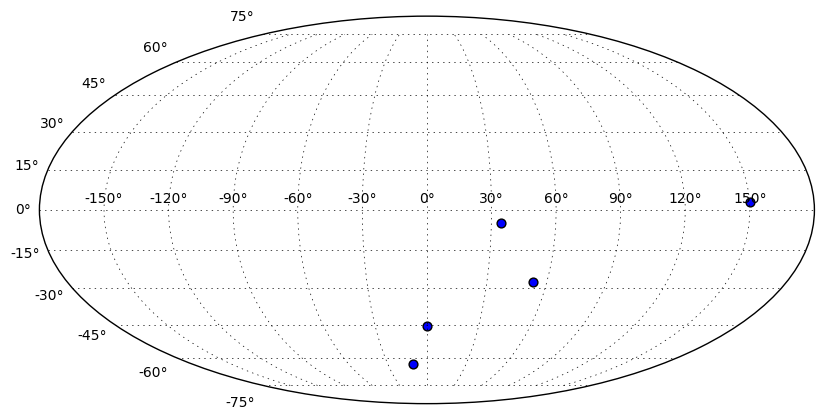

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide');
fig = OpSimDeepSummary.showFields(ax=fig.axes[0], marker='o', s=40)

## How often do multiple DDF fields get observed ?

In [21]:
DDF_fieldIDs = OpSim_Deep.fieldID.unique()
DDF_fieldIDs

array([1427, 2786,  290,  744, 2412])

In [22]:
grouped = OpSim_Deep[['night', 'fieldID']].groupby(['night'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12b887e10>], dtype=object)

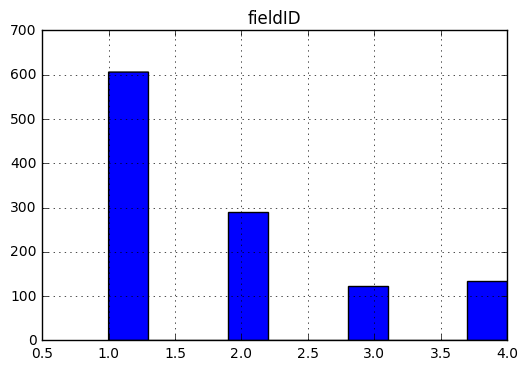

In [23]:
fig, ax = plt.subplots()
grouped.agg({'fieldID': lambda x: x.unique().size}).hist(ax=ax)

In [24]:
fig.savefig('DeepOnly_uniqueDDFFields.png')

What about if we count WFD visits to these fields ?

In [25]:
OpSimCombined_DDF_Fields = OpSim_combined.query('fieldID in @DDF_fieldIDs')

In [26]:
len(OpSimCombined_DDF_Fields)

114225

In [27]:
OpSimCombined_DDF_Fields.fieldID.unique()

array([ 744, 2412, 1427, 2786,  290])

In [28]:
combinedGrouped = OpSimCombined_DDF_Fields.groupby('night')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12fca8ed0>], dtype=object)

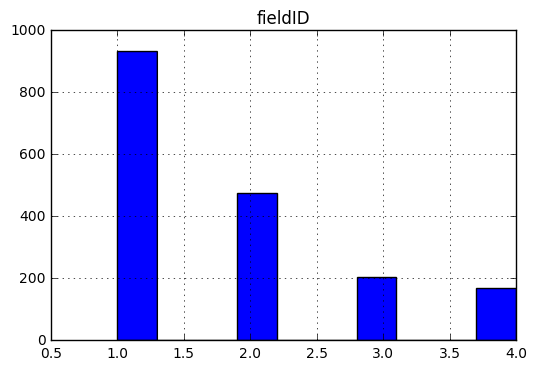

In [29]:
fig, ax = plt.subplots()
combinedGrouped.agg({'fieldID': lambda x: x.unique().size}).hist(ax=ax)

In [30]:
fig.savefig('Combined_DDFvisits.png')

#### Example plotting of a single field

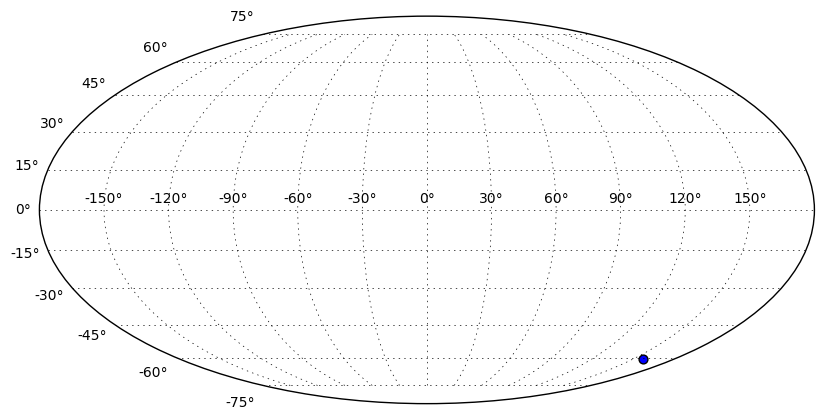

In [31]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide');
opsimFieldSummary = so.SummaryOpsim(OpSim_combined.query('fieldID==347'))
fig = opsimFieldSummary.showFields(ax=fig.axes[0], marker='o', s=40)

### Plot all fields

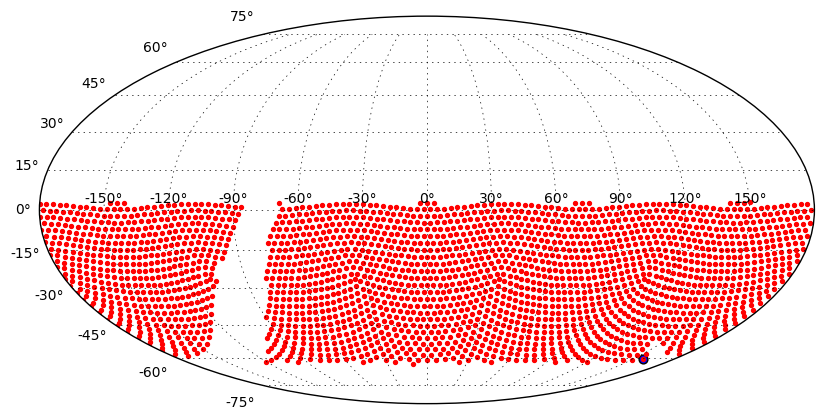

In [32]:
OpSimCombinedSummary.showFields(ax=ax, marker='o', color='r', s=8)

In [33]:
fieldIDFromRADec = oss.fieldID(OpSim_Deep, np.radians(53.), np.radians(-28.))
print fieldIDFromRADec

1427.0


In [34]:
fieldIDFromRADec = oss.fieldID(OpSim_Deep, np.radians(0.), np.radians(-45.))
print fieldIDFromRADec

744.0


In [35]:
fieldIDFromRADec = oss.fieldID(OpSim_combined, np.radians(53.), np.radians(-28.))
print fieldIDFromRADec

1427.0


In [36]:
fieldIDFromRADec = oss.fieldID(OpSim_combined, np.radians(85.7), np.radians(-14.4))
print fieldIDFromRADec

2001.0


In [57]:
fieldList = OpSimCombinedSummary.fieldIds

##  Obtain a list of filters, mjds, depths, and field ra, dec for deep fields

In [38]:
OpSim_combined.columns

Index([u'sessionID', u'propID', u'fieldID', u'fieldRA', u'fieldDec', u'filter',
       u'expDate', u'expMJD', u'night', u'visitTime', u'visitExpTime',
       u'finRank', u'FWHMeff', u'FWHMgeom', u'transparency', u'airmass',
       u'vSkyBright', u'filtSkyBrightness', u'rotSkyPos', u'rotTelPos', u'lst',
       u'altitude', u'azimuth', u'dist2Moon', u'solarElong', u'moonRA',
       u'moonDec', u'moonAlt', u'moonAZ', u'moonPhase', u'sunAlt', u'sunAz',
       u'phaseAngle', u'rScatter', u'mieScatter', u'moonIllum', u'moonBright',
       u'darkBright', u'rawSeeing', u'wind', u'humidity', u'slewDist',
       u'slewTime', u'fiveSigmaDepth', u'ditheredRA', u'ditheredDec'],
      dtype='object')

In [39]:
DDF_fieldIDs

array([1427, 2786,  290,  744, 2412])

In [40]:
selectedFields = OpSim_combined.query('fieldID in @DDF_fieldIDs')[['expMJD', 'propID', 'filter', 'fieldRA', 'fieldDec', 'fieldID', 'fiveSigmaDepth']]#.head()

In [41]:
selectedFields.head()

,expMJD,propID,filter,fieldRA,fieldDec,fieldID,fiveSigmaDepth
obsHistID,,,,,,,
132712,59760.431760,54,z,0.0,-0.794553,744,22.088572
132741,59760.445023,54,z,0.0,-0.794553,744,22.037498
138180,59770.355327,54,y,0.0,-0.794553,744,21.921016
138192,59770.362167,54,r,0.0,-0.794553,744,24.264669
141306,59773.317909,54,y,0.0,-0.794553,744,21.852082


In [42]:
selectedFields.to_hdf('DDF_Fields_Info.hdf', 'summaryInfo')

/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)
/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  f(store)
/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packa

In [43]:
# CHECK
read_table = pd.read_hdf('DDF_Fields_Info.hdf', 'summaryInfo')

In [44]:
read_table.head()

,expMJD,propID,filter,fieldRA,fieldDec,fieldID,fiveSigmaDepth
obsHistID,,,,,,,
132712,59760.431760,54,z,0.0,-0.794553,744,22.088572
132741,59760.445023,54,z,0.0,-0.794553,744,22.037498
138180,59770.355327,54,y,0.0,-0.794553,744,21.921016
138192,59770.362167,54,r,0.0,-0.794553,744,24.264669
141306,59773.317909,54,y,0.0,-0.794553,744,21.852082


In [45]:
from pandas.util.testing import assert_frame_equal

In [46]:
assert_frame_equal(read_table, selectedFields)

#### First Season

We can visualize the cadence during the first season using the cadence plot for a particular field: The following plot shows how many visits we have in different filters on a particular night:

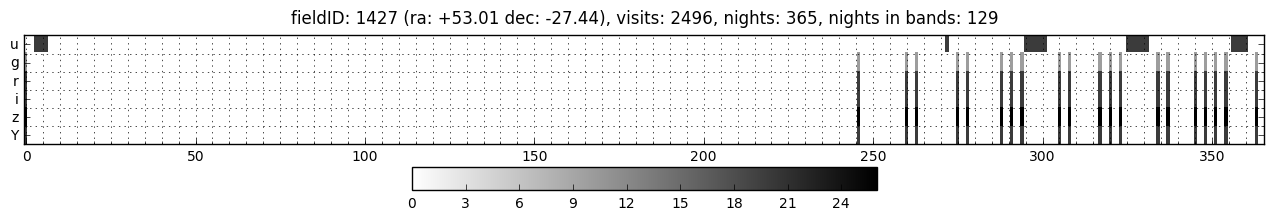

In [47]:
firstSeasonDeep = OpSimDeepSummary.cadence_plot(fieldID=1427, observedOnly=False, sql_query='night < 366')

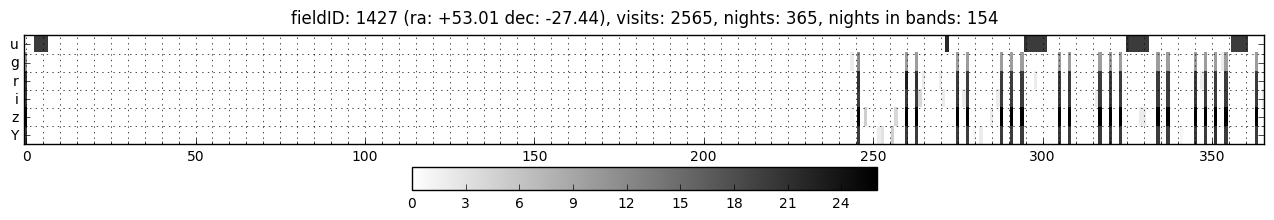

In [48]:
firstSeasonCombined = OpSimCombinedSummary.cadence_plot(fieldID=1427, observedOnly=False, sql_query='night < 366')

In [80]:
firstSeasonCombined[0].savefig('minion_1427.pdf')

In [53]:
firstSeason_main[0].savefig('minion_1430.pdf')

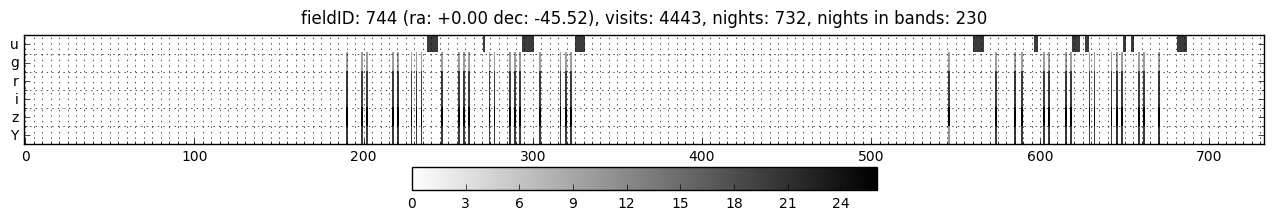

In [49]:
firstSeason = OpSimDeepSummary.cadence_plot(fieldID=744, observedOnly=False, sql_query='night < 732', 
                                             nightMin=0, nightMax=732)

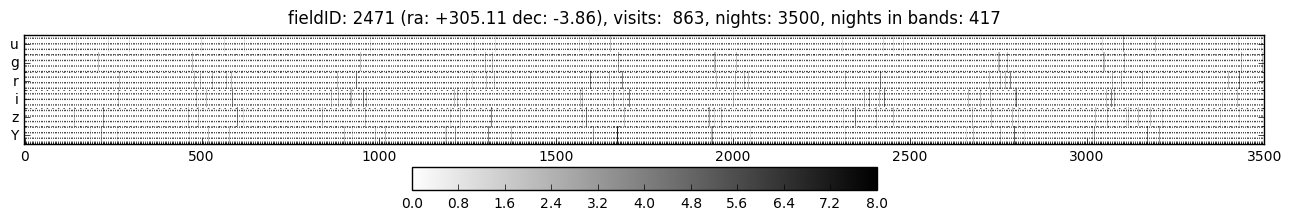

In [58]:
tenCadence = OpSimCombinedSummary.cadence_plot(fieldID=fieldList[2000], observedOnly=False, sql_query='night < 3500', nightMax=3500)

Suppose we have a supernova with a peak around a particular MJD of 49540, and we want to see what the observations happened around it:

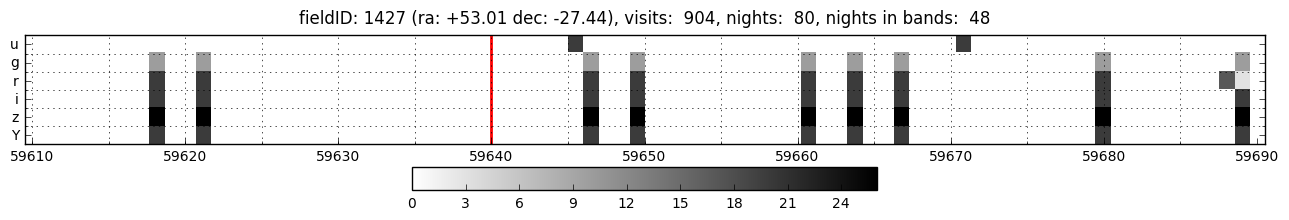

In [51]:
SN = OpSimDeepSummary.cadence_plot(summarydf=OpSimDeepSummary.df, fieldID=1427, #racol='fieldRA', deccol='fieldDec',
                                                  observedOnly=False, mjd_center=59640., mjd_range=[-30., 50.])
# ax = plt.gca()
# ax.axvline(49540, color='r', lw=2.)
# ax.xaxis.get_major_formatter().set_useOffset(False)

In [52]:
SN[0].savefig('SN_observaton.pdf')

# Scratch

In [ ]:
SN_matrix.sum(axis=1).sum()

In [ ]:
EnigmaDeep.query('fieldID == 744 and expMJD < 49590 and expMJD > 49510').expMJD.size

In [41]:
SN_matrix[SN_matrix > 0.5] = 1

In [52]:
SN_matrix.sum().sum()

336.0

In [55]:
len(SN_matrix.sum(axis=1).dropna())

7

In [56]:
nightlySN_matrix = SN_matrix.copy(deep=True)

In [57]:
nightlySN_matrix[SN_matrix > 0.5] =1

In [64]:
nightlySN_matrix.sum(axis=1).dropna().sum()

18.0

In [69]:
nightlySN_matrix.sum(axis=1).dropna().size

7

In [ ]:
nightlySN_matrix.sum(ax)